## Analyse exploratoire série temporelle - fct_respiratory

In [132]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

In [19]:
columns = ['etco2','eto2','fico2','fin2o','fr','fr_ecg','fio2','mac','peeptotal','pmax','pmean','pplat','rr_co2','spo2','svo2__m','vt']

In [124]:
#read data 

fct_respiratory = pd.read_csv('fct_respiratory.csv')
dim_patient = pd.read_csv('dim_patient.csv')
dates = dim_patient[['id_patient','date_transplantation']]

#merge two dataframes per id_patient

df = pd.merge(fct_respiratory, dates, on='id_patient')
df['timestamp'] = df['date_transplantation'] + '-' +df['time']

#remove time = 0 

df = df[df['time'] != '0']

df['timestamp'] = pd.to_datetime(df['timestamp'])

In [125]:
df_melt = pd.melt(df, id_vars=['id_patient','timestamp'], value_vars=columns)

In [134]:
def plot_respiratory(df, id_patient):
    print 'Displaying respiratory measures for patient # {}'.format(id_patient)
    g = sns.FacetGrid(df[df['id_patient'] == id_patient], col="variable", col_wrap=4, sharey=False)
    g = g.map(plt.plot, "timestamp", "value")

Displaying respiratory measures for patient # 381


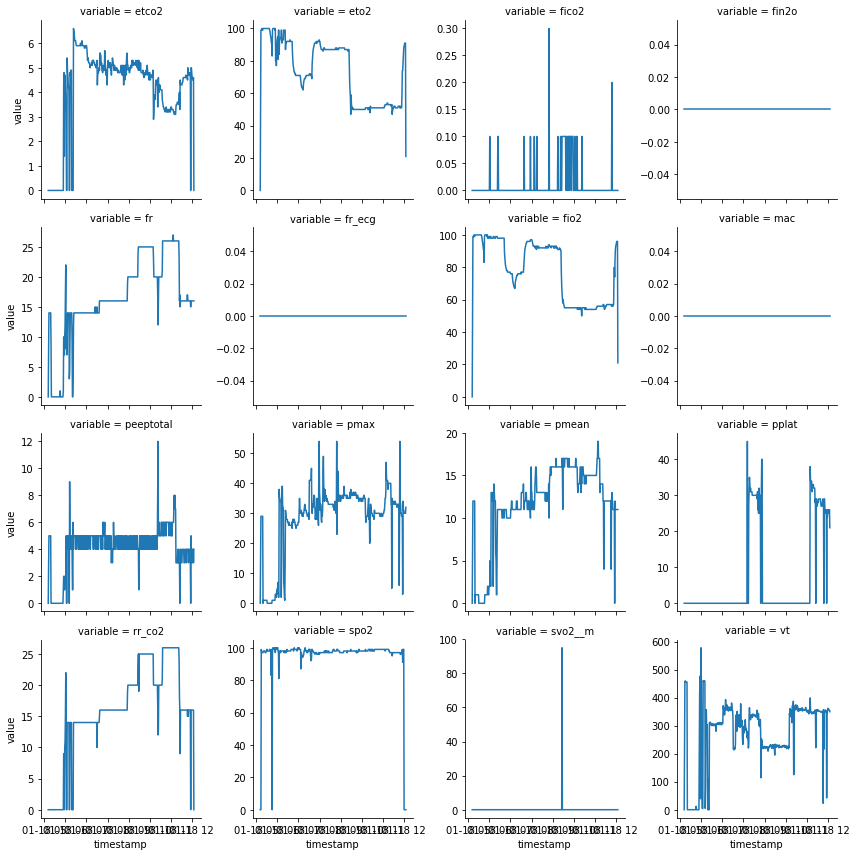

In [136]:
plot_respiratory(df_melt, 381)

In [96]:
def plot_metric_patient(metric, id_patient):
    print 'Displaying respiratory measure {} for patient # {}'.format(metric, id_patient)
    df_tmp = df_melt[df_melt['id_patient'] == id_patient]
    df_tmp[df_tmp.variable == metric].plot(x='timestamp', y='value')

## Supprimer les valeurs anormales

Un des challenges dans le traitement des timeseries est la présence de valeurs anormales. Ces valeurs peuvent apparaitre car un instrument de mesure n'est pas correctement configuré etc.. Voici un exemple de valeur anormale: 

Displaying respiratory measure svo2__m for patient # 381


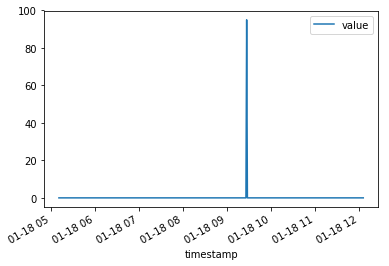

In [99]:
plot_metric_patient('svo2__m', 381)

Dans l'exemple ci-dessus une minute du set a une valeur anormale. Nous proposons ici de réaliser un simple check et de supprimer toute valeur supérieur au quantile 0.99. Nous ajoutons les bornes des quantiles au dataframe df_melt, puis nous filtrons les valeurs entre les bornes: 

In [112]:
def above_quantile(x):
    result = {'q_99': x['value'].quantile(0.99), 
              'q_1': x['value'].quantile(0.01)}
    return pd.Series(result, name='quantiles')

quant_df = df_melt.groupby(['id_patient', 'variable']).apply(above_quantile).reset_index()
df_tmp_lim = pd.merge(df_melt, quant_df)

In [140]:
df_melt_2 = df_tmp_lim[df_tmp_lim['value'] > df_tmp_lim['q_1']]

Displaying respiratory measures for patient # 381


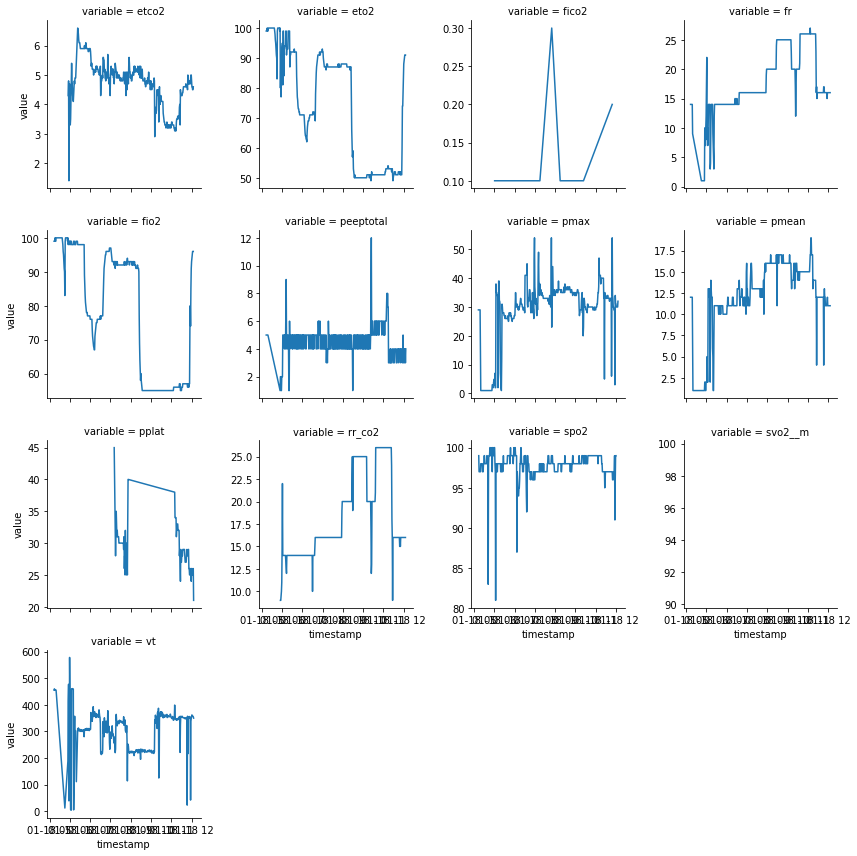

In [141]:
plot_respiratory(df_melt_2, 381)

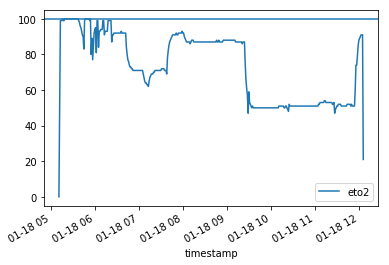

In [75]:
plt = df1.plot.line(x='timestamp', y='eto2')
plt.axhline(100)

In [81]:
plt = df1.plot.point(x='timestamp', y='svo2__m')

AttributeError: 'FramePlotMethods' object has no attribute 'point'

In [ ]:
df.plot.scatter(x='timestamp',
                y='width',
                c='species',
                colormap='viridis')